In [1]:
import numpy as np
from solver import freq_top_opt_2D

In [2]:
%matplotlib inline

In [3]:
verbose = False
if not verbose:
    import warnings
    warnings.filterwarnings("ignore")

In [4]:
r = 1 # mesh refinement factor
scaling =  20e-9/r # the scale applied to the physical problem
fR = int(6*r) #int(r*3) # value for the filtering radius   
nElx = int(r*200) + 2*fR #400 # the number of elements in the X axis
nEly = int(r*100) + 2*fR #200 # the number of elements in the Y axis
tElmIdx = [int(r*100)+ fR, int(r*40)+ fR] #[200,100] # the target element for the optimization of the FOM
thickness = int(r*10) #15 # the thickness of the design region, in number of elements in the Y direction
limit = int(np.floor((nEly-2*fR)*9/10))+fR # the lower limit of the design region, 0.9 * total height of the simulation volume
dVElmIdx = np.array([np.arange(limit-thickness,limit),np.arange(fR,nElx-fR)])  # the indexes of the domain of the  design variables

DVini = 0.0 * np.ones(len(dVElmIdx[0])*len(dVElmIdx[1])) # the initial value / guess for the design parameters
#np.random.seed(42)
#DVini = np.random.rand(len(dVElmIdx[0])*len(dVElmIdx[1]))

thickness_part = int(r*35)
height_part = int(r*35)
dVElmIdx_part = np.array([np.arange(tElmIdx[1]-height_part//2,tElmIdx[1]+height_part//2),np.arange(tElmIdx[0]-thickness_part//2,tElmIdx[0]+thickness_part//2)])  # the indexes of the domain of the  design variables
dVElmIdx_part_pad = np.array([np.arange(tElmIdx[1]-height_part//2-fR,tElmIdx[1]+height_part//2+fR),np.arange(tElmIdx[0]-thickness_part//2-fR,tElmIdx[0]+thickness_part//2+fR)])  # the indexes of the domain of the  design variables

DVini_part =1 * np.ones(len(dVElmIdx_part[0])*len(dVElmIdx_part[1])) # the initial value / guess for the design parameters


#DVini_part = np.random.rand(len(dVElmIdx_part[0])*len(dVElmIdx_part[1]))
eps = 4 # value of the dielectric function
eps_part = 4 # value of the dielectric function of the particle
part_shape = "design" # shape of the particle
part_size = int(r*10) # the size of the particle
wl = int(r*35)  #35  # value for the wavelentgth, i.e. 35 nm.
maxItr = 500 # number of iterations performed by the optimizer
alg = "MMA" # algorithm: Method of  Moving Asymptotes
eta = 0.5
beta = 75
solver = freq_top_opt_2D( tElmIdx,
                          dVElmIdx,
                          dVElmIdx_part,
                          dVElmIdx_part_pad,
                          nElx, 
                          nEly,
                          DVini,
                          DVini_part,  
                          eps, 
                          wl,  
                          fR,
                          eta, 
                          beta,
                          scaling,
                          part_shape,
                          part_size,
                          eps_part
                        )

In [5]:
dVs_part = np.load("designs/dVs_part_test.npy") 
#len_dVs = len(dVElmIdx[0])*len(dVElmIdx[1])
#lend_dVs_part = len(dVElmIdx_part[0])*len(dVElmIdx_part[1])
#dVs =  dVs_tot[:len_dVs]
#dVs_part = dVs_tot[len_dVs:]

In [6]:
beta =  64.072265625 #42.71484375 #64.072265625 repulsive V1 #18.984375 attractive V1

FOM:  (18639449054687.695+0j)
Elapsed time in iteration: 0 min 10 s
----------------------------------------------


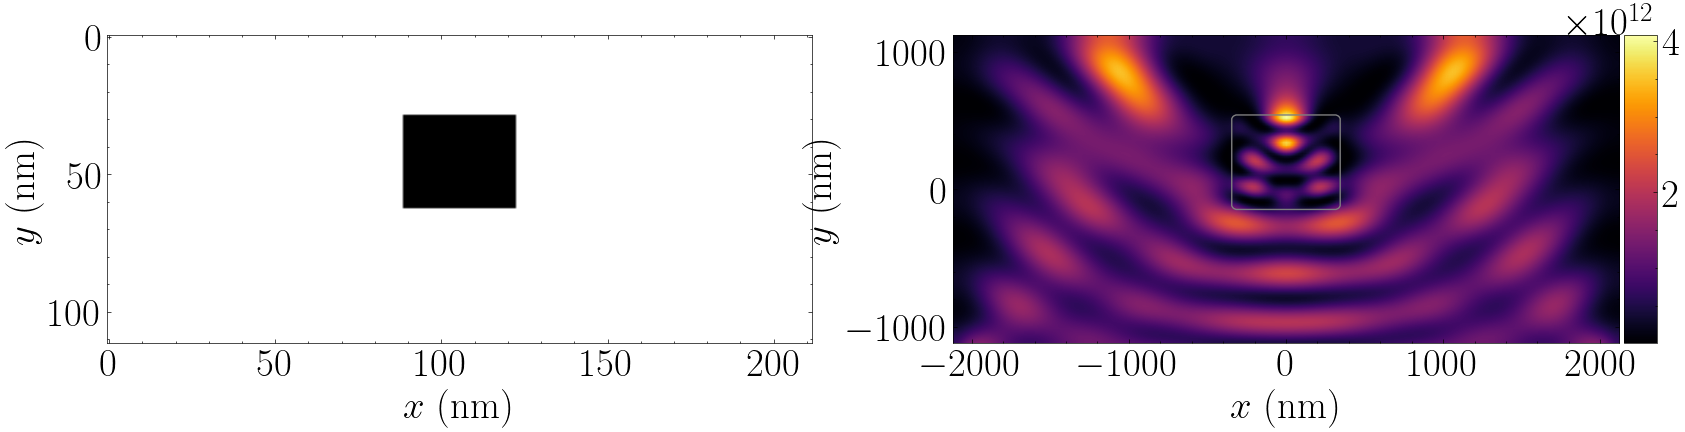

1729277.915068437


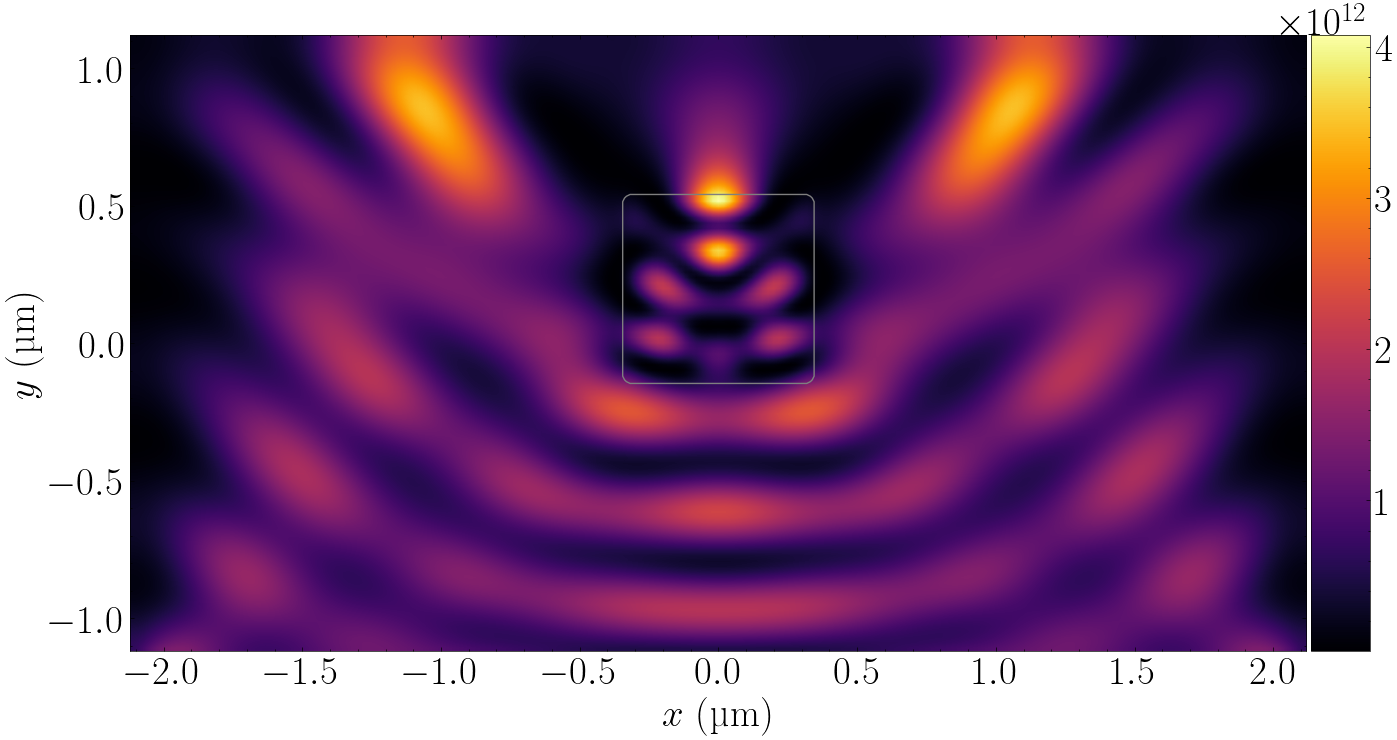

In [7]:
Ez, FOM = solver.solve_forward(DVini, np.ones_like(dVs_part))

In [8]:
solver.calculate_forces()

Fx:  (-3.019806626980426e-22+0j)
Fy:  (2.7959173582031544e-06+0j)


In [9]:
raise()

TypeError: exceptions must derive from BaseException

In [ ]:
real_design_variables = solver.dis_0.dFPST.T + solver.dis_0.dFPST_part.T
import scipy.io
mdic = {"matrix": real_design_variables, "label": "optimized"}
scipy.io.savemat('designs/test.mat', mdic)

In [ ]:
raise()

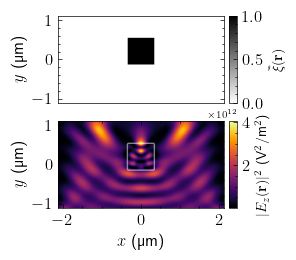

In [10]:
from plot import init_plot_params
init_plot_params(46)

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from functions import resize_el_node

plt.rcParams.update(plt.rcParamsDefault)
import scienceplots
import matplotlib as mpl
#mpl.rcParams.update({"font.size": 28})
#fig, ax = plt.subplots(figsize=(10,6))
with plt.style.context(['science', 'nature']):

        f  = 1 
        fig, ax = plt.subplots(2,1,figsize=(f*2.5, f*2.5))
        dis = solver.dis_0

        extent = [-0.5*dis.nElx*dis.scaling * 1e6, 0.5*dis.nElx*dis.scaling * 1e6, -0.5*dis.nEly*dis.scaling * 1e6, 0.5*dis.nEly*dis.scaling * 1e6]

        #ax[0].set_title("Attractive system", fontsize=40)
    
        divider = make_axes_locatable(ax[1])
        cax = divider.append_axes('right', size='5%', pad=0.05)

        divider0 = make_axes_locatable(ax[0])
        cax0 = divider0.append_axes('right', size='5%', pad=0.05)

        design_field =  np.reshape(np.real(dis.dFPST+dis.dFP_part), (dis.nodesY-1, dis.nodesX-1))
        im0 = ax[0].imshow(design_field, cmap='binary', extent=extent)
        im = ax[1].imshow(np.reshape(np.real(dis.Ez*np.conj(dis.Ez)), (dis.nodesY, dis.nodesX)), cmap='inferno', interpolation='bilinear', extent=extent)
        eps = resize_el_node(dis.edofMat, np.real(dis.A).flatten(), dis.nElx, dis.nEly)
        eps = np.reshape(eps, (dis.nodesY, dis.nodesX))
        ax[1].contour(np.real(eps), levels=1, colors='white', linewidths=1, alpha=0.5, extent=extent, origin="upper")
        cb0 = fig.colorbar(im0, cax=cax0, orientation='vertical', label="$\\bar{\\tilde{\\xi}}(\mathbf{r})$")
        cb1 = fig.colorbar(im, cax=cax, orientation='vertical', label="$|E_z(\mathbf{r})|^2$")

        cb0.ax.tick_params(labelsize=f*12)  # Set fontsize of the colorbar ticks
        cb1.ax.tick_params(labelsize=f*12)  # Set fontsize of the colorbar ticks
        cb0.set_label(label="$\\bar{\\tilde{\\xi}}(\mathbf{r})$", fontsize=f*10)
        cb1.set_label(label="$|E_z(\mathbf{r})|^2$ (V$^2$/m$^2$)", fontsize=f*10)

        ax[0].set_xticklabels([])
        ax[0].set_xticks([])

        ax[1].set_xlabel('$x$ (\\textmu m)', fontsize=f*12)
        for axis in ax:
                axis.set_ylabel('$y$ (\\textmu m)', fontsize=f*12)
                axis.tick_params(axis='both', which='major', labelsize=f*12)

        
plt.show()


In [11]:
fig.savefig('plots/square_free.pdf', bbox_inches='tight')